# 13주 2강 Linear Regression (최소자승법)

Allen B. Downey의 http://thinkstats2.com 코드를 참조했습니다.

이번 강의는 최소자승법 (Least squares fitting)에 대해서 배우겠습니다.

In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

In [2]:
preg = pd.read_csv("./2002FemPreg.tsv", sep = "\t")
live = preg[preg.outcome == 1].dropna(subset=["agepreg", "totalwgt_lb"])
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]
ages = live.agepreg
weights = live.totalwgt_lb

## Least Squares
다시한 번 NSFG데이터를 다뤄봅시다. 

In [3]:
def LeastSquares(xs, ys):
    meanx = np.mean(xs)
    varx = np.var(xs)
    meany = np.mean(ys)
    cov = np.cov(xs, ys)
    
    slope = cov[0, 1] / varx # 지난 시간 강의를 참조하세요
    inter = meany - slope * meanx
    return inter, slope

In [4]:
# 실제로 절편(intercept)과 기울기(slope)를 구해봅시다
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.830348812252711, 0.017455782848528653)

In [5]:
# intercept는 independent variable (x, 여기서는 age)가 0일 때 y축과 만나는 점입니다
# 하지만 independent variable의 평균에 대해서 값을 보는 것이 더 적절할 수 있습니다. 
print(np.mean(ages))
print(inter + slope*np.mean(ages))

24.93612856826679
7.265628457623368


In [6]:
# slope는 나이가 1년 단위로 보면 너무 작아서 이해가 힘들 수도 있습니다.
# 나이 10년 차이가 얼마나 차이를 보일까요?
slope * 10

0.17455782848528653

In [7]:
# 실제 그림을 그려봅시다. 아래의 함수는 입력된 xs 값에 대해서 y의 fitted 값을 리턴해주는 함수입니다. 
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [8]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

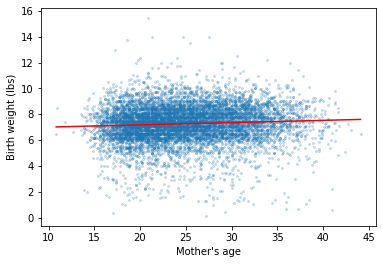

In [9]:
plt.plot(fit_xs, fit_ys, color="red")
plt.scatter(ages, weights, s=4, alpha=0.2)
plt.xlabel("Mother's age")
plt.ylabel("Birth weight (lbs)")
plt.show()

## Residual
residual은 y의 실제 관측값과 fitted line에서 추정한 값의 차이를 의미합니다

In [10]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [11]:
# Dataframe의 collumns는 아래와 같이 추가할 수도 있습니다.
live['residual'] = Residuals(ages, weights, inter, slope)

In [40]:
# residual을 산모의 나이 별로 구분하고, percentile plot을 그려봅시다

In [13]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

In [14]:
def values2cdf(values):
    sorted_values = sorted(values)
    total = len(values)
    x = []
    y = []
    for i, value in enumerate(sorted_values):
        x.append(value)
        y.append(i/total)
    return x, y

In [15]:
cdfs = [values2cdf(group.residual) for _, group in groups][1:-1]

In [16]:
def PlotPercentiles(age_means, cdfs):
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf[0][int(percent * len(cdf[0]) / 100)] for cdf in cdfs]
        label = '%dth' % percent
        print(weight_percentiles)
        plt.plot(age_means, weight_percentiles, label=label)

[0.7276458738157414, 0.7814262797937443, 0.7754913136252446, 0.9280880453304547, 0.8786881798691182, 0.8916137565792974, 0.9338650484750035, 0.9235744339966399, 0.7622664056717001, 0.631339736905467]
[-0.10527739211703757, 0.03142627979374435, 0.05465076838455474, 0.12134845367046942, 0.09813226248192564, 0.1039009682242078, 0.09081742849007846, 0.07039416255730035, 0.004934976875317965, -0.32658352902731114]
[-0.9118424259485378, -0.8203575290177127, -0.7506923606475482, -0.7258968516003703, -0.6649595746544703, -0.7566107320115139, -0.8597744086463175, -0.7407093748148172, -1.1026092402761538, -0.9835359090423861]


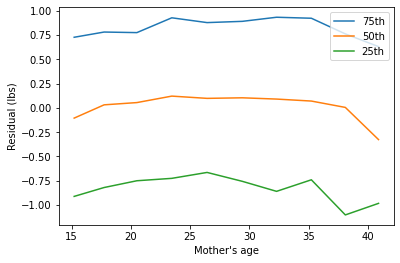

In [17]:
PlotPercentiles(age_means, cdfs)
plt.xlabel("Mother's age")
plt.ylabel("Residual (lbs)")
plt.legend()
plt.show()

In [18]:
# redual의 curvate가 있네요. 이런 형태는 non-linear relationship 일 때 자주 나타납니다.

## Sampling distribution

inter와 slope의 distribution을 보고 싶을 때는, dataset을 sampling해서 여러 번 테스트 해 보면 됩니다. 

In [19]:
def SampleRows(df, nrows, replace=False):
    # 한번 뽑히면 다시 뽑히지 않는 경우는 SampleRows를 씁니다. 
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    # 한번 뽑은 것을 다시 뽑는 경우는 ResampleRows를 씁니다. 
    return SampleRows(df, len(df), replace=True)

In [20]:
# iter 수 만큼 distribution을 뽑아서, inter와 slope를 구하는 SampleDistributions 함수를 만들어봅시다
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [21]:
inters, slopes = SamplingDistributions(live, iters=1001)

In [22]:
# 요약통계를 내주는 함수를 만들어봅시다.
def Summarize(estimates):
    mean = np.mean(estimates)
    stderr = np.std(estimates)
    cdf = values2cdf(estimates)
    ci_90 = cdf[0][int(0.05 * len(cdf[0]))], cdf[0][int(0.95 * len(cdf[0]))] # 90% confidence interval
    print('mean, SE, CI', mean, stderr, ci_90)

In [23]:
# inters의 요약통계를 내 봅시다
Summarize(inters)

mean, SE, CI 6.829369431766404 0.06730618974450915 (6.715798566977063, 6.940015127299503)


In [24]:
# inters의 요약통계를 내 봅시다
Summarize(slopes)

mean, SE, CI 0.01751111098730297 0.0026955627488821996 (0.013272311705872062, 0.02202825800670808)


In [25]:
# resample rows로 해 봅시다
inters, slopes = SamplingDistributions(live, iters=1001)
Summarize(inters)
Summarize(slopes)

mean, SE, CI 6.831048990449172 0.07152778144013341 (6.715033146001071, 6.950199571771731)
mean, SE, CI 0.017403950046008046 0.0028205962463469653 (0.012697010873756343, 0.02196424521529103)


## Visualizing uncertainty
위에서 구한 estimate를 시각화 해 봅시다.

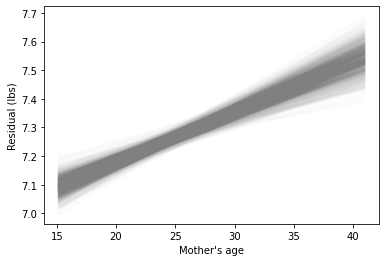

In [26]:
# 모든 선을 반투명하게 만들어 겹치는 방법으로 쉽게 볼 수 있습니다
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    plt.plot(fxs, fys, color='gray', alpha=0.01, linewidth=3)

plt.xlabel("Mother's age")
plt.ylabel("Residual (lbs)")
plt.show()

In [27]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)
    fys_2darray = np.stack(fys_seq, axis=0)
    p = (100 - percent) / 2
    percents = p, 100 - p
    low = [sorted(fys_2darray[:,i])[int(percents[0] / 100 * len(fys_2darray[:,i]))] for i in range(len(xs))]
    high = [sorted(fys_2darray[:,i])[int(percents[1] / 100 * len(fys_2darray[:,i]))] for i in range(len(xs))]
    plt.fill_between(fxs, low, high, **options)

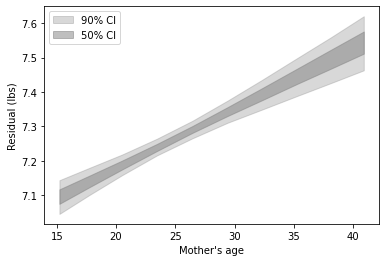

In [28]:
# 산모의 연령과 아이 몸무게의 Confidence interval들을 그려 봅시다. 

PlotConfidenceIntervals(age_means, inters, slopes, percent=90, color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50, color='gray', alpha=0.5, label='50% CI')

plt.xlabel("Mother's age")
plt.ylabel("Residual (lbs)")
plt.legend(loc=2)
plt.show()

## Coefficient of determination (결정계수)

지난시간에 배웠듯, 결정계수는 residual과 dependent variable의 variance를 비교하는 것입니다. (SSR vs SSE) 

In [41]:
def CoefDetermination(ys, res):
    return 1 - np.var(res) / np.var(ys)

In [30]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.0047381154166924455

In [31]:
# 사실 R^2값은 pearson correlation의 제곱과 같습니다. 

print('rho', np.corrcoef(ages, weights)[0][1])
print('R', np.sqrt(r2))

rho 0.06883397035410903
R 0.06883396993267529


In [32]:
# dependent variable과 residual의 standard deviation을 비교해봅시다. 
print('Std(ys)', np.std(weights))
print('Std(res)', np.std(res))

Std(ys) 1.4082155338406195
Std(res) 1.4048754288267307


## Hypothesis testing with slopes

In [33]:
# 지난시간에 만들었던 HypotehsisTest를 다시 가져옵시다.

class HypothesisTest(object):
    # 공통적으로 많이 사용할 Method들에 대한 HyothesisTest class를 만들어둡니다

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None
        self.test_cdf = None        

    def PValue(self, iters=1000):
        # p-value는 가설에 대해서 현재 관측한 data나 worse data가 나올 확률입니다.
        # simulation을 통해서 p-value를 구해봅시다.
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()
        
    def MaxTestStat(self):
        return max(self.test_stats)

    def values2cdf(self, values):
        sorted_values = sorted(values)
        total = len(values)
        x = []
        y = []
        for i, value in enumerate(sorted_values):
            x.append(value)
            y.append(i/total)
        return x, y    
    
    def PlotCdf(self, label=None):
        self.test_cdf = self.values2cdf(self.test_stats)
        def VertLine(x):
            plt.plot([x, x], [0, 1], color='0.8')
        VertLine(self.actual)
        plt.plot(self.test_cdf[0], self.test_cdf[1], label=label)

In [34]:
# 이제 slope 값으로 가설 검정을 해 봅시다. 
class SlopeTest(HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [35]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue
# pvalue 계산값은 0이네요, 이 말은 1000개의 샘플을 썼으므로 p-value < 0.001 이라는 뜻입니다. iteration을 더 큰 값을 쓰면 더 정확한 값을 구할 수 있을겁니다.

0.0

In [36]:
ht.actual, ht.MaxTestStat()

(0.017455782848528653, 0.009200235945687214)

In [37]:
sampling_cdf = values2cdf(slopes)

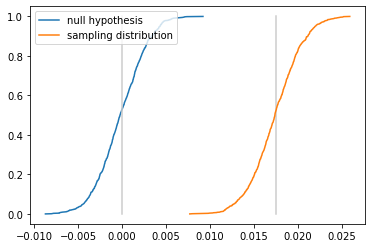

In [38]:
ht.PlotCdf(label='null hypothesis')
plt.plot([0, 0], [0, 1], color='0.8')

plt.plot(sampling_cdf[0], sampling_cdf[1], label='sampling distribution')
plt.legend(loc=2)
plt.show()

In [39]:
# 두 개의 CDF를 비교해 봅시다. 수직선은 0과, 실제 slope의 추정값인 0.017 lbs/year입니다. 
# 1000 개의 sample중 null hypothesis를 가정하여 나올 수 있는 sample이 한 개도 없습니다.
# 1000 개의 sample을 보았으므로 p < 0.001이라고 생각할 수 있습니다.